# Surfline Recruitment Project

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style = 'darkgrid')
import os
import datetime
import missingno as mn
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [87]:
# set up our paths to the data
CWD = os.getcwd()
DATA_PATH = os.path.join(CWD, 'surfline_recruitment_project', 'data')

# I want to join all df's myself, so I won't include buoy_all or oahu_all
BUOY_PATHS = [os.path.join(DATA_PATH, path) for path in os.listdir(DATA_PATH) if ('buoy' in path) and ('all' not in path)]
OAHU_PATHS = [os.path.join(DATA_PATH, path) for path in os.listdir(DATA_PATH) if ('oahu' in path) and ('all' not in path)]

Before doing any EDA, I want to build the entire buoy and oahu data from each year. I make sure to convert the "9's" that are missing values into NA's. Once the df's for both buoy and oahu data are created, I can filter the buoy df to only contain the maximum of the day. Finally, I merge the two df's by date and we can explore the features.

# Open and Create DataFrames
Pre-process the data

In [88]:
# now let's create a pipeline to read all buoy data
class BuildBuoyData():
    NA_list = [99.0,999.0,9999.0]
    
    def __init__(self, data_paths):
        self.data_paths = data_paths
    def OpenDF(self):
        """
        This will create a large DF for every file in the path
        """
        concat_df = pd.DataFrame()
        for path in self.data_paths:
            # read table
            df = pd.read_table(path, delim_whitespace = True)
            df.drop(df.index[0], inplace = True)
            # add date
            df['date'] = pd.to_datetime(df['#YY']+df['MM']+df['DD']+df['hh']+df['mm'], format = '%Y%m%d%H%M')

            # remove the extra columns
            df.drop(['#YY','MM','DD','hh','mm'], axis = 1, inplace = True)
            
            # let's convert the types to float and turn the 9's into NA
            for column in df.columns:
                if 'date' not in column:
                    df[column] = df[column].astype('float64')
                    df[column] = df[column].apply(lambda x: np.nan if x in self.NA_list else x)
                    
            concat_df = pd.concat([concat_df, df], axis = 0)
        concat_df.set_index('date', inplace = True)
        concat_df.sort_index()
        return concat_df

In [89]:
# make the df for all buoy data
buoy = BuildBuoyData(BUOY_PATHS)
buoy_df = buoy.OpenDF()

In [90]:
# examine df
print(buoy_df.head())
print(buoy_df.shape)

                     WDIR  WSPD  GST  WVHT    DPD   APD    MWD  PRES  ATMP  \
date                                                                         
2010-01-01 00:21:00   NaN   NaN  NaN  2.44  13.33  9.40  331.0   NaN   NaN   
2010-01-01 00:51:00   NaN   NaN  NaN  2.51  14.29  9.29  326.0   NaN   NaN   
2010-01-01 01:21:00   NaN   NaN  NaN  2.30  14.29  8.81  317.0   NaN   NaN   
2010-01-01 01:51:00   NaN   NaN  NaN  2.83  13.33  9.89  319.0   NaN   NaN   
2010-01-01 02:21:00   NaN   NaN  NaN  2.49  13.33  9.44  324.0   NaN   NaN   

                     WTMP  DEWP  VIS  TIDE  
date                                        
2010-01-01 00:21:00  24.7   NaN  NaN   NaN  
2010-01-01 00:51:00  24.8   NaN  NaN   NaN  
2010-01-01 01:21:00  24.7   NaN  NaN   NaN  
2010-01-01 01:51:00  24.7   NaN  NaN   NaN  
2010-01-01 02:21:00  24.7   NaN  NaN   NaN  
(115040, 13)


Missing Buoy Data


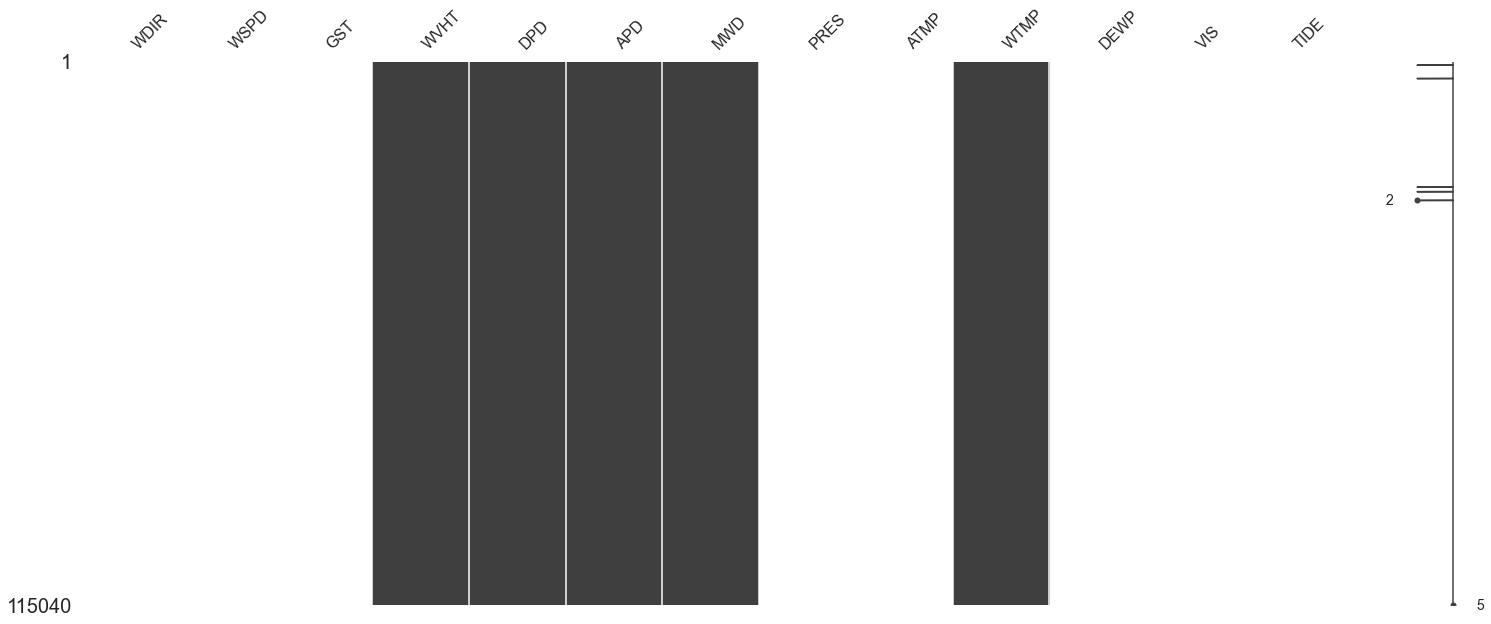

In [91]:
# visualize missing data
print('Missing Buoy Data')
mn.matrix(buoy_df)
plt.show()

In [92]:
# let's do the same for oahu
class BuildOahuData():
    NA_list = [99.0,999.0,9999.0]

    def __init__(self, data_paths):
        self.data_paths = data_paths
    def OpenDF(self):
        concat_df = pd.DataFrame()
        for path in self.data_paths:
            df = pd.read_table(path, delim_whitespace = True, names = ['year', 'month','day','nshor','wshor',
                                                                       'almo','dh','winw','wspd','wdir','nsd','ssd'])
            # convert year, month, and day to str
            time_columns = ['year', 'month', 'day']
            for time in time_columns:
                df[time] = df[time].astype('str')
            # add date
            df['date'] = pd.to_datetime(df['year'] + df['month'] + df['day'], format = '%Y%m%d')
            # remove extra date features
            df.drop(['year', 'month', 'day'], axis = 1, inplace = True)
            
            # let's convert the types to float and turn the 9's into NA
            for column in df.columns:
                if 'date' not in column:
                    df[column] = df[column].astype('float64')
                    df[column] = df[column].apply(lambda x: np.nan if x in self.NA_list else x)
                    
            concat_df = pd.concat([concat_df, df], axis = 0)
        concat_df.set_index('date', inplace = True)
        concat_df.sort_index()
        return concat_df

In [93]:
# make df for all oahu data
oahu = BuildOahuData(OAHU_PATHS)
oahu_df = oahu.OpenDF()
oahu_df.index = oahu_df.index.strftime('%Y-%m-%d')
oahu_df.head()

,nshor,wshor,almo,dh,winw,wspd,wdir,nsd,ssd
date,,,,,,,,,
2010-01-01,6.0,4.0,2.0,3.0,4.0,3.0,2.0,16.0,13.0
2010-01-02,7.0,4.0,2.0,2.0,3.0,2.0,17.0,14.0,NaN
2010-01-03,6.0,4.0,2.0,2.0,2.0,4.0,11.0,15.0,NaN
2010-01-04,6.0,3.0,2.0,2.0,2.0,4.0,11.0,14.0,NaN
2010-01-05,18.0,6.0,2.0,2.0,2.0,4.0,11.0,14.0,NaN


In [94]:
oahu_df.shape

(2559, 9)

Missing data for oahu dataframe


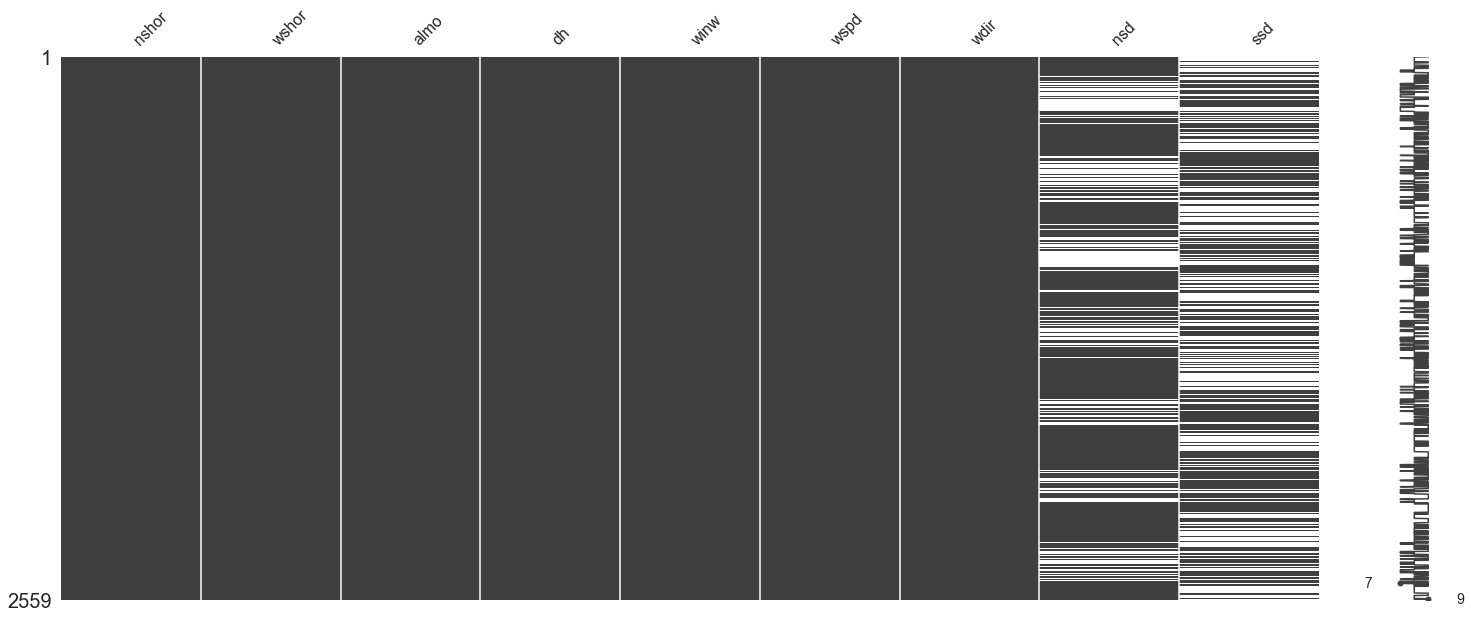

In [95]:
# visualize missing values
print('Missing data for oahu dataframe')
mn.matrix(oahu_df)
plt.show()
# looks like we are missing a lot for nsd and ssd

Both df's are created. Now I will filter the oahu df by the max of the day. I noticed in the './preprocess_data_example.ipynb' that the df was filtered to include daylight hours only. This makes sense and I will do the same before continuing.

# Filtering the Buoy dataframe

In [96]:
# first we shift the time by 10 hours
buoy_df.index = buoy_df.index + datetime.timedelta(hours = -10)
# next we filter so that the hours are between 7 and 17 (daylight hours
rows_before = buoy_df.shape[0]
print('Shape before filtering: {}\n'.format(buoy_df.shape))

buoy_df = buoy_df.loc[lambda df: (df.index.hour >= 7) & (df.index.hour  <= 17), :]
print('Shape after filtering: {}\n'.format(buoy_df.shape))
rows_after = buoy_df.shape[0]
print('Number of rows filtered: {}'.format(rows_before - rows_after))

Shape before filtering: (115040, 13)

Shape after filtering: (52605, 13)

Number of rows filtered: 62435


In [97]:
max_WVHT_idx = buoy_df.groupby([buoy_df.index.year, buoy_df.index.month, buoy_df.index.day])['WVHT'].idxmax()
buoy_df = buoy_df.loc[max_WVHT_idx]
print('Shape after aggregating and keeping max WVHT: {}'.format(buoy_df.shape))

Shape after aggregating and keeping max WVHT: (2484, 13)


In [98]:
buoy_df.head()

,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,TIDE
date,,,,,,,,,,,,,
2009-12-31 15:51:00,NaN,NaN,NaN,2.83,13.33,9.89,319.0,NaN,NaN,24.7,NaN,NaN,NaN
2010-01-01 08:51:00,NaN,NaN,NaN,2.28,11.11,7.38,332.0,NaN,NaN,24.4,NaN,NaN,NaN
2010-01-02 13:51:00,NaN,NaN,NaN,1.96,15.38,10.52,314.0,NaN,NaN,24.9,NaN,NaN,NaN
2010-01-03 08:51:00,NaN,NaN,NaN,1.84,14.29,9.22,319.0,NaN,NaN,24.6,NaN,NaN,NaN
2010-01-04 07:51:00,NaN,NaN,NaN,2.15,11.11,7.43,312.0,NaN,NaN,24.8,NaN,NaN,NaN


The index for oahu only includes year, month, and day. So I will set the index for buoy to be the same and then we can merge the datasets

In [99]:
buoy_df.index = buoy_df.index.strftime('%Y-%m-%d')
buoy_df.head()

,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,TIDE
date,,,,,,,,,,,,,
2009-12-31,NaN,NaN,NaN,2.83,13.33,9.89,319.0,NaN,NaN,24.7,NaN,NaN,NaN
2010-01-01,NaN,NaN,NaN,2.28,11.11,7.38,332.0,NaN,NaN,24.4,NaN,NaN,NaN
2010-01-02,NaN,NaN,NaN,1.96,15.38,10.52,314.0,NaN,NaN,24.9,NaN,NaN,NaN
2010-01-03,NaN,NaN,NaN,1.84,14.29,9.22,319.0,NaN,NaN,24.6,NaN,NaN,NaN
2010-01-04,NaN,NaN,NaN,2.15,11.11,7.43,312.0,NaN,NaN,24.8,NaN,NaN,NaN


# Merge the two dataframes

In [100]:
# merge the two dataframes by date
all_data = pd.merge(buoy_df, oahu_df, how = 'outer', left_index = True, right_index = True)
all_data.head()

,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,...,TIDE,nshor,wshor,almo,dh,winw,wspd,wdir,nsd,ssd
date,,,,,,,,,,,,,,,,,,,,,
2009-12-31,NaN,NaN,NaN,2.83,13.33,9.89,319.0,NaN,NaN,24.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-01,NaN,NaN,NaN,2.28,11.11,7.38,332.0,NaN,NaN,24.4,...,NaN,6.0,4.0,2.0,3.0,4.0,3.0,2.0,16.0,13.0
2010-01-02,NaN,NaN,NaN,1.96,15.38,10.52,314.0,NaN,NaN,24.9,...,NaN,7.0,4.0,2.0,2.0,3.0,2.0,17.0,14.0,NaN
2010-01-03,NaN,NaN,NaN,1.84,14.29,9.22,319.0,NaN,NaN,24.6,...,NaN,6.0,4.0,2.0,2.0,2.0,4.0,11.0,15.0,NaN
2010-01-04,NaN,NaN,NaN,2.15,11.11,7.43,312.0,NaN,NaN,24.8,...,NaN,6.0,3.0,2.0,2.0,2.0,4.0,11.0,14.0,NaN


In [101]:
all_data.shape

(2685, 22)

Missing data for merged dataframe


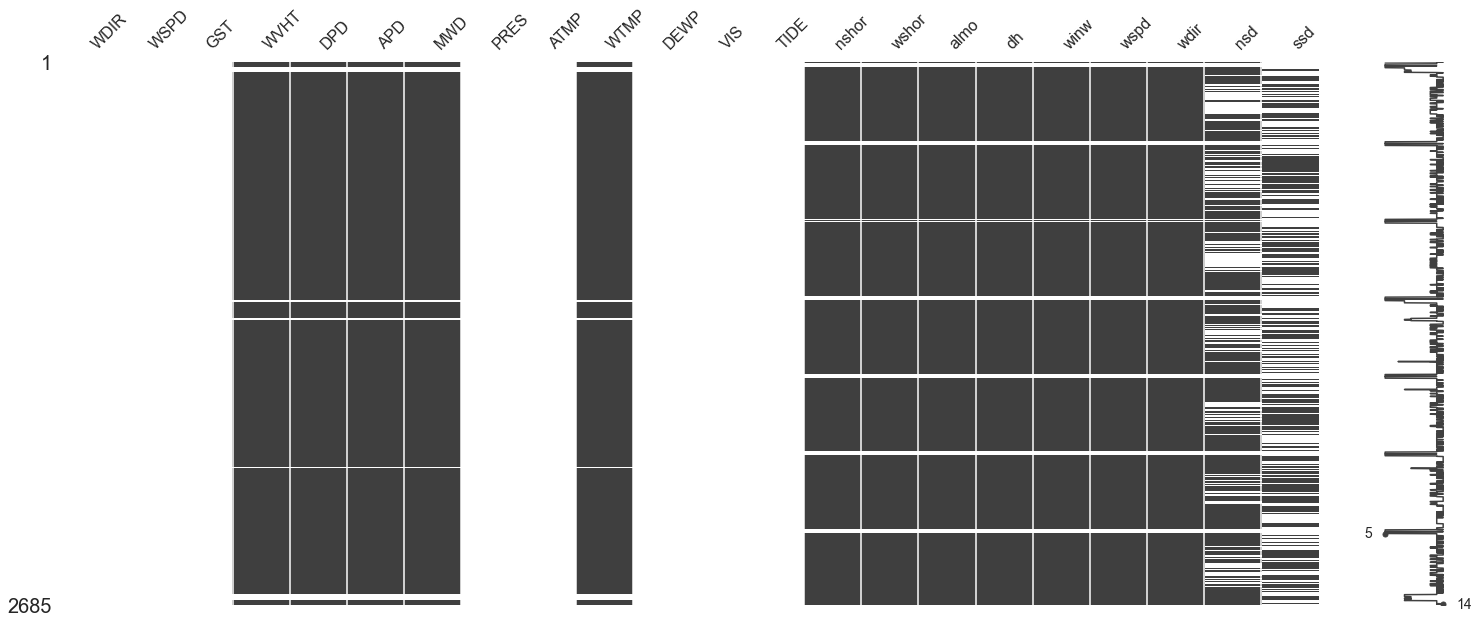

In [102]:
# visualize the merged df
print('Missing data for merged dataframe')
mn.matrix(all_data)
plt.show()

Some of the columns of the Buoy_df have no values. I could drop, but I will keep them just in case they generate values in the future.

# Exploratory Data Analysis

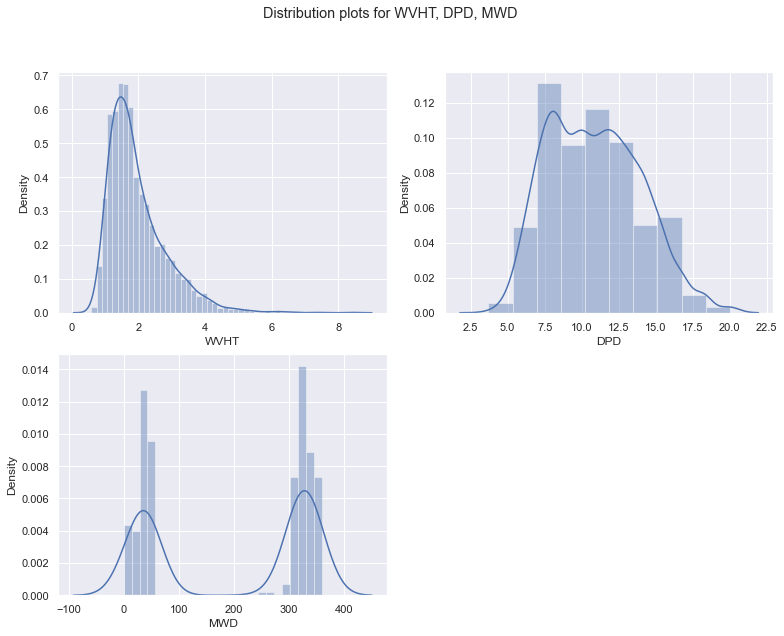

In [103]:
# let's visualize the ditribution of WVHT, DPD, and MWD
fig, axs = plt.subplots(2,2, figsize = (11,9))

g = sns.distplot(a = all_data['WVHT'],
                 kde = True,
                 color = 'b',
                 ax = axs[0][0])

g = sns.distplot(a = all_data['DPD'],
                 kde = True,
                 color = 'b',
                 ax = axs[0][1],
                 bins = 10)

g = sns.distplot(a = all_data['MWD'],
                 kde = True,
                 color = 'b',
                 ax = axs[1][0],
                 bins = 25)

fig.delaxes(axs[1][1])
fig.tight_layout()
fig.suptitle('Distribution plots for WVHT, DPD, MWD')
fig.subplots_adjust(top=0.88)
plt.show()

We can see that a lot of the WVHT values range from 1 to 3 meters. There are two clusters of frequencies for MWD: around 0-50 degrees and around 300-350 degrees. This means most of the swell comes from NNE and NW. Finally, the periods mostly range from 7.5 to 17.5 seconds.

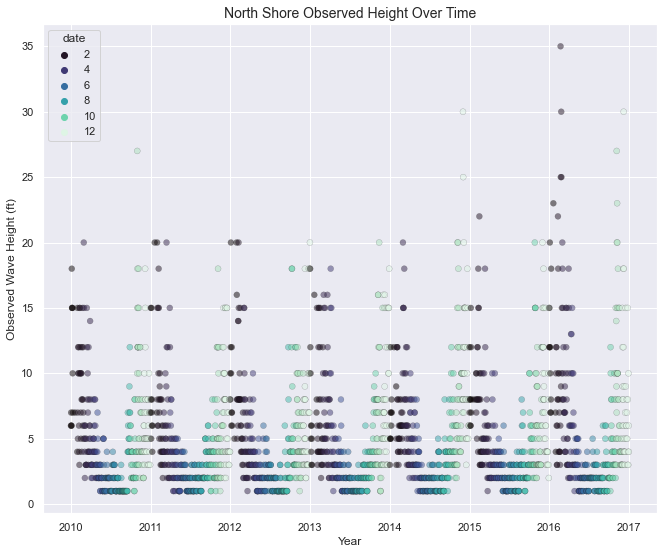

In [104]:
# let's plot the target against time
plt.figure(figsize = (11,9))

all_data.index = pd.to_datetime(all_data.index)

g = sns.scatterplot(x = all_data.index,
                    y = all_data['nshor'],
                    hue = all_data.index.month,
                    palette = 'mako',
                    alpha = 0.5,
                    linewidth = 0.25,
                    edgecolor = 'k')


g.set(xlabel = 'Year')
g.set(ylabel = 'Observed Wave Height (ft)')
plt.title('North Shore Observed Height Over Time', fontsize = 14)
plt.show()

We can see some nice patterns! I have colored the scatter plot by month so that it is easier to see how the wave height changes over time. I wonder if we get the same pattern for the buoy data. Let's see.

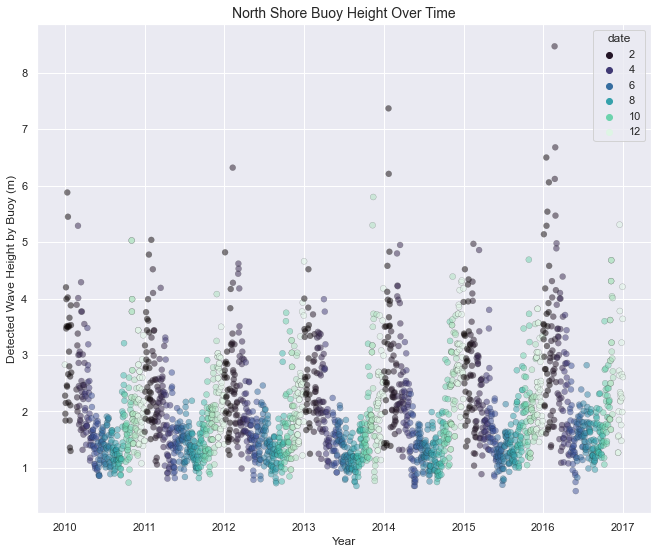

In [105]:
plt.figure(figsize = (11,9))

g = sns.scatterplot(x = all_data.index,
                    y = all_data['WVHT'],
                    hue = all_data.index.month,
                    palette = 'mako',
                    alpha = 0.5,
                    linewidth = 0.25,
                    edgecolor = 'k')


g.set(xlabel = 'Year')
g.set(ylabel = 'Detected Wave Height by Buoy (m)')
plt.title('North Shore Buoy Height Over Time', fontsize = 14)
plt.show()

The buoy data over time looks very similar to the observed wave height. We can see that the wave height is smallest in the summer months and larger in the winter months. I think it is worth adding a column for seasons to our dataset to see how much this hypothesis holds true.

In [106]:
def add_seasons(df):
    """
    This function will add the season (winter, spring, summer, fall) based on the month
    Spring: March, April, May
    Summer: June, July, August
    Fall: September, October, November
    Winter: December, January, February
    """
    df['Month'] = df.index.month
    months = df.index.month.unique()
    df['Season'] = df['Month']
    for month in months:
        if month in [12,1,2]:
            df.loc[lambda df: df['Month'] == month, 'Season'] = 'Winter'
        elif month in [3,4,5]:
            df.loc[lambda df: df['Month'] == month, 'Season'] = 'Spring'
        elif month in [6,7,8]:
            df.loc[lambda df: df['Month'] == month, 'Season'] = 'Summer'
        else:
            df.loc[lambda df: df['Month'] == month, 'Season'] = 'Fall'
    return df

In [107]:
all_data = add_seasons(all_data)
all_data.head()

,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,...,wshor,almo,dh,winw,wspd,wdir,nsd,ssd,Month,Season
date,,,,,,,,,,,,,,,,,,,,,
2009-12-31,NaN,NaN,NaN,2.83,13.33,9.89,319.0,NaN,NaN,24.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,Winter
2010-01-01,NaN,NaN,NaN,2.28,11.11,7.38,332.0,NaN,NaN,24.4,...,4.0,2.0,3.0,4.0,3.0,2.0,16.0,13.0,1,Winter
2010-01-02,NaN,NaN,NaN,1.96,15.38,10.52,314.0,NaN,NaN,24.9,...,4.0,2.0,2.0,3.0,2.0,17.0,14.0,NaN,1,Winter
2010-01-03,NaN,NaN,NaN,1.84,14.29,9.22,319.0,NaN,NaN,24.6,...,4.0,2.0,2.0,2.0,4.0,11.0,15.0,NaN,1,Winter
2010-01-04,NaN,NaN,NaN,2.15,11.11,7.43,312.0,NaN,NaN,24.8,...,3.0,2.0,2.0,2.0,4.0,11.0,14.0,NaN,1,Winter


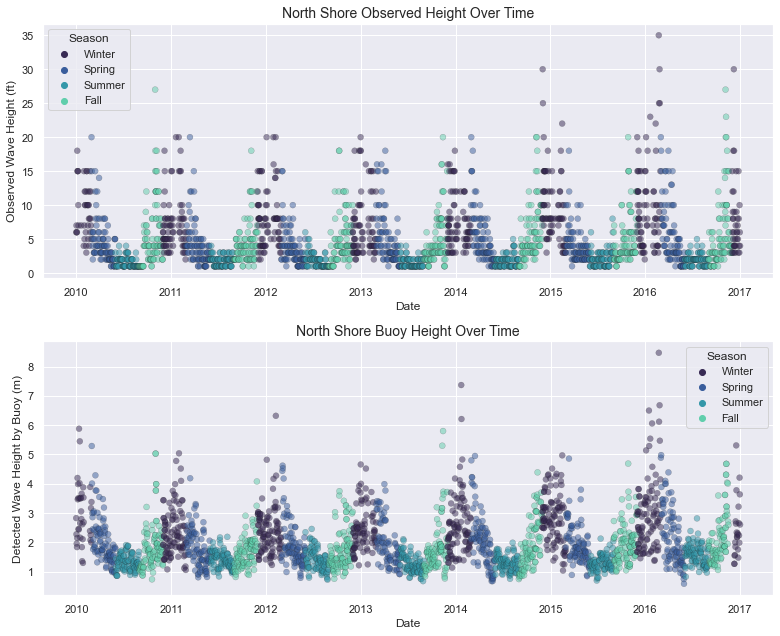

In [108]:
# we'll plot the graphs above on top of eachother this time. And we will color by season

fig, axs = plt.subplots(2,1, figsize = (11,9))

g = sns.scatterplot(x = all_data.index,
                    y = all_data['nshor'],
                    hue = all_data['Season'],
                    palette = 'mako',
                    alpha = 0.5,
                    linewidth = 0.25,
                    edgecolor = 'k',
                    ax = axs[0])
axs[0].set_title('North Shore Observed Height Over Time', fontsize = 14)
axs[0].set(xlabel = 'Date')
axs[0].set(ylabel = 'Observed Wave Height (ft)')

g = sns.scatterplot(x = all_data.index,
                    y = all_data['WVHT'],
                    hue = all_data['Season'],
                    palette = 'mako',
                    alpha = 0.5,
                    linewidth = 0.25,
                    edgecolor = 'k',
                    ax = axs[1])

axs[1].set_title('North Shore Buoy Height Over Time', fontsize = 14)
axs[1].set(xlabel = 'Date')
axs[1].set(ylabel = 'Detected Wave Height by Buoy (m)')

fig.tight_layout()
plt.show()

The patterns definitely match up! We can clearly see that Winter, Fall, and even Spring have larger wave heights while Summer is typically smaller. Let's verify this numerically by observing the median of each season.

In [109]:
def season_medians(df):
    print('--- Season Medians ---')
    tmp_df = df.copy() # don't want to acccidentally change the df
    seasons = tmp_df['Season'].unique()
    for season in seasons:
        # filter the df by season
        tmp = tmp_df.loc[lambda df: df['Season'] == season, :]
        nshor_median = tmp['nshor'].median()
        WVHT_median = tmp['WVHT'].median()
        print('For {}:'.format(season))
        print('Observed North Shore Height: {} (ft)'.format(nshor_median))
        print('Detected North Shore Height: {} (m)\n'.format(WVHT_median))
        print('-----------------------')

In [110]:
season_medians(all_data)

--- Season Medians ---
For Winter:
Observed North Shore Height: 7.0 (ft)
Detected North Shore Height: 2.47 (m)

-----------------------
For Spring:
Observed North Shore Height: 3.0 (ft)
Detected North Shore Height: 1.81 (m)

-----------------------
For Summer:
Observed North Shore Height: 2.0 (ft)
Detected North Shore Height: 1.33 (m)

-----------------------
For Fall:
Observed North Shore Height: 4.0 (ft)
Detected North Shore Height: 1.72 (m)

-----------------------


Just like we thought, Summer is the smallest season for both observed wave height and detected wave height by the buoy. Unsurprisingly, Winter takes the lead for largest waves.

# Predicting Wave Heights

It is now time to build a (simple) ML model to predict our wave heights.
First, we need to deal with the missing values. Since the target is nshor, I will drop any of the rows that are missing from that target. I don't want to have to guess what those target values are and potentially add more bias to the model.

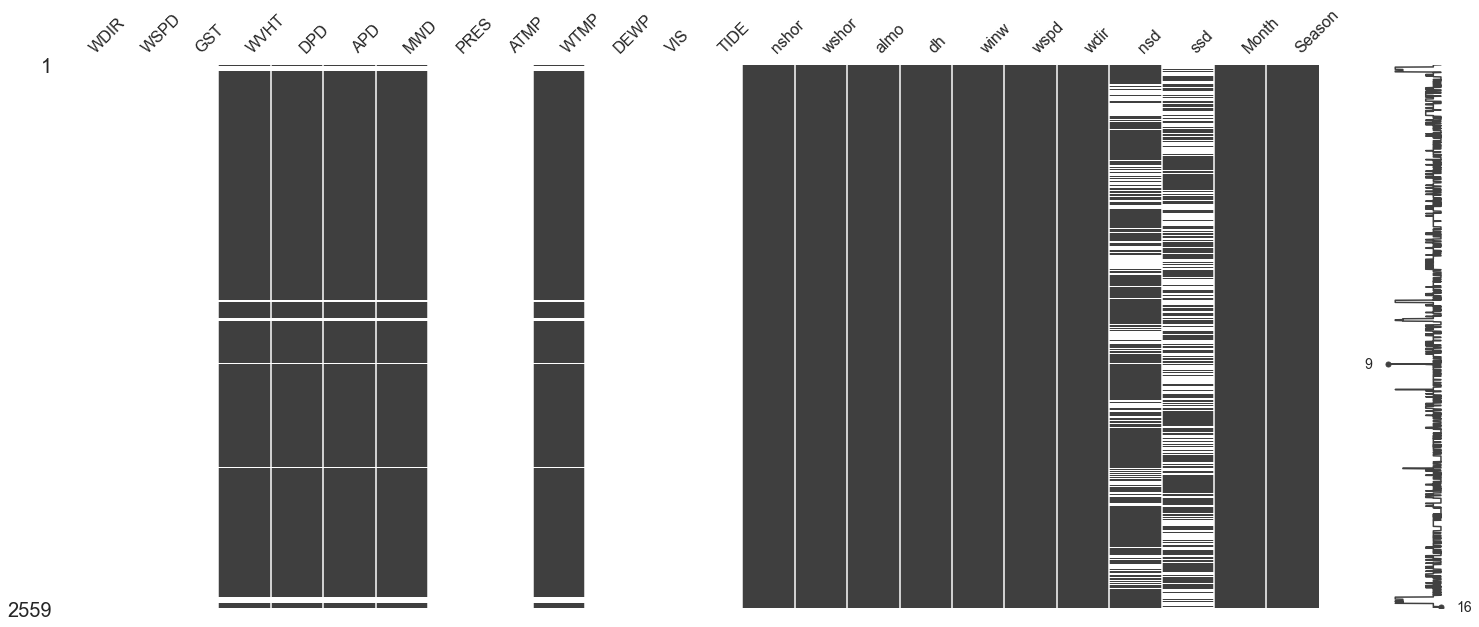

In [111]:
all_data.dropna(subset = ['nshor'], axis = 0, how = 'any', inplace = True)
mn.matrix(all_data)
plt.show()

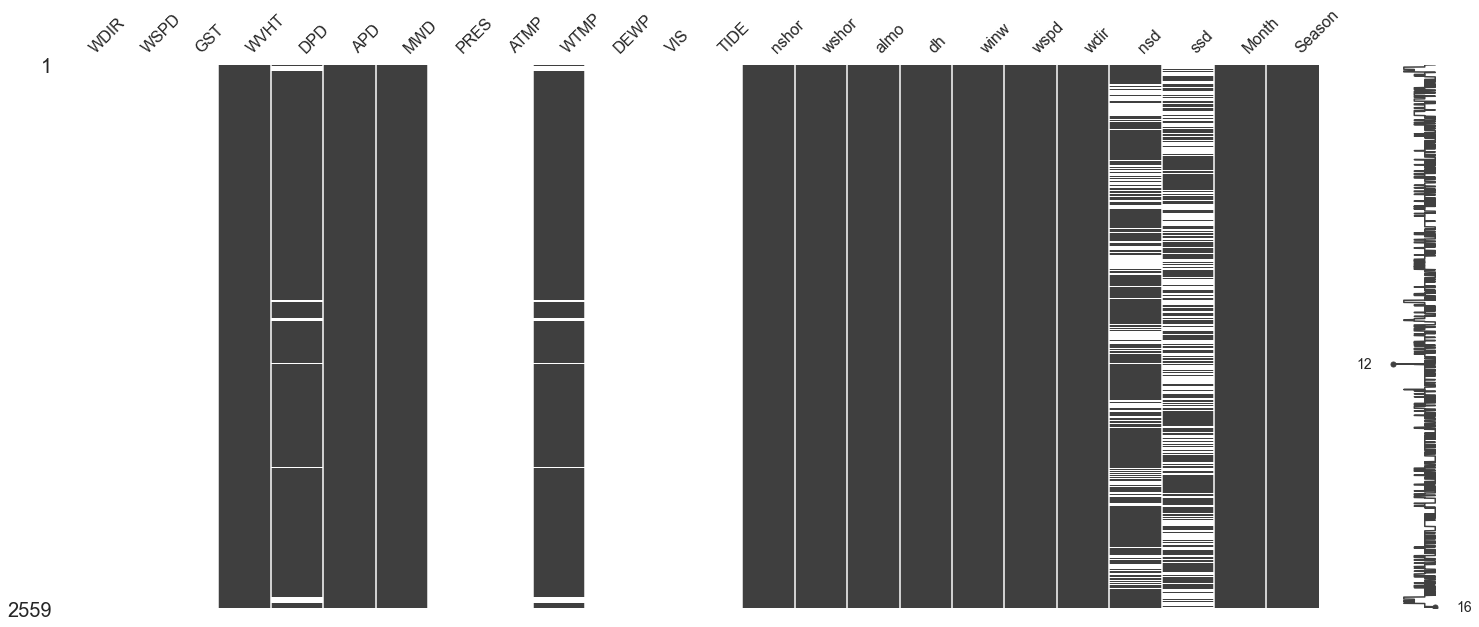

In [112]:
# now we will impute the missing values from WVHT, MWD, and PDP using interpolation. 
#Specifically, we will interpolate from derivatives
features = ['WVHT', 'APD', 'MWD']
for column in features:
    all_data[column] = all_data[column].astype('float64')
    all_data[column].interpolate(method = 'from_derivatives', inplace = True)
    
mn.matrix(all_data)
plt.show()

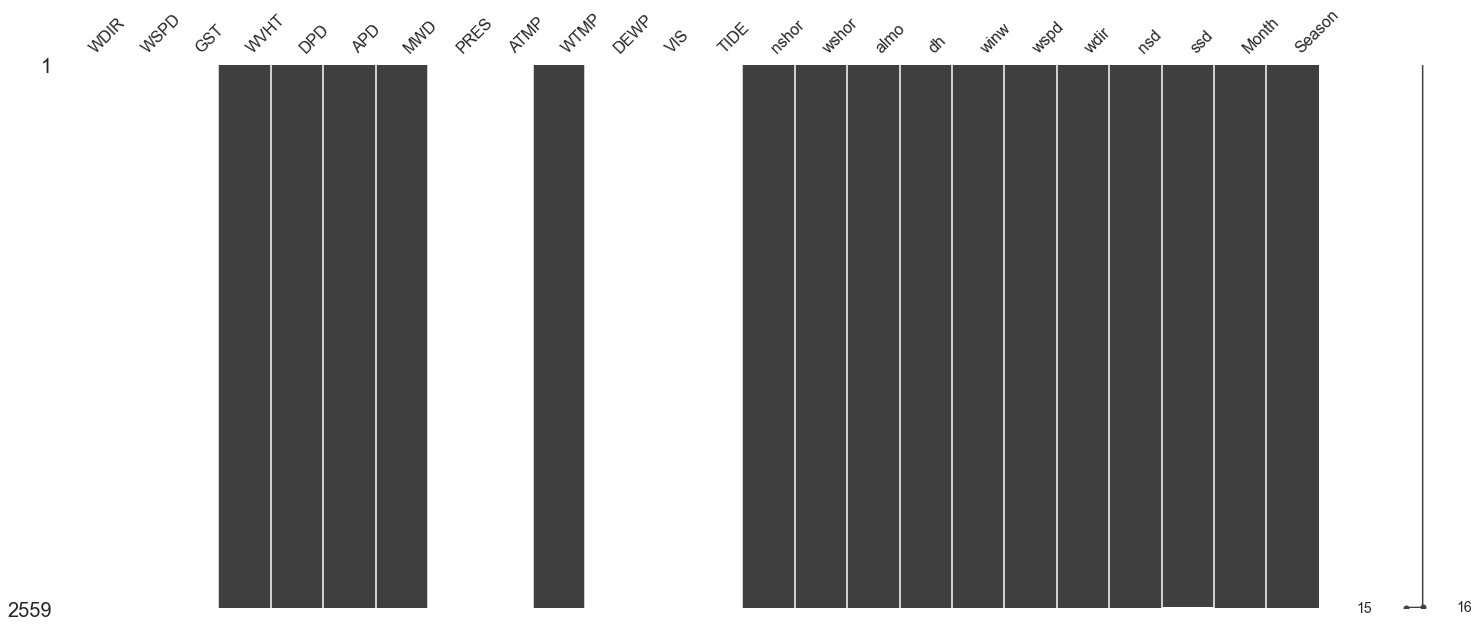

In [113]:
# finally, we will fill any remaining missing values with pd.fillna
remaining_features = ['DPD','WTMP','nsd','ssd']

for feature in remaining_features:
    all_data[feature] = all_data[feature].astype('float64').fillna(method = 'backfill')

mn.matrix(all_data)
plt.show()

# Baseline Model

We will use sklearn to split the data, then we will train a few models to have a baseline. Then, we will use GridSearchCV to find optimal hyperparameters for the highest performing model.

In [114]:
# necessary imports
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

In [115]:
# split the data
X = all_data[features].values
y = all_data['nshor'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [116]:
def trainModel(models, X, y):
    modelScores = {}
    for model in models:
        scores = cross_val_score(model, X, y, scoring = 'neg_mean_absolute_error', cv = 10)
        avgScore = scores.mean()
        modelScores[model] = avgScore
    return modelScores


In [117]:
models = [RandomForestRegressor(random_state = 1),
          Ridge(),
          SVR()]

In [118]:
# before training, we will scale the data. 
#Scaling is not necessary for Random Forests, but it can make training faster for Ridge and SVR

scaler = StandardScaler()
X_train_tr = scaler.fit_transform(X_train)
X_test_tr = scaler.fit_transform(X_test)

In [119]:
# now we train
modelScores = trainModel(models, X_train_tr, y_train)

for model in modelScores:
    print(model, modelScores[model])

RandomForestRegressor(random_state=1) -1.1847703342556537
Ridge() -1.292063547133983
SVR() -1.0422047028567625


SVR (Support Vector Regression) performed best with default hyperparameters and a few training features.

# Optimize and Outperform Baseline

I will now use GridSearchCV on SVR to find the optimal hyperparamters. I will also feed the model more data ('DPD','WTMP','nsd','ssd' and the seasons!)

In [120]:
# first, let's use pd.dummies to encode the season features
all_data = pd.get_dummies(all_data, columns = ['Season'])

In [121]:
rename_dict = {'Season_Fall': 'Fall',
               'Season_Spring': 'Spring',
               'Season_Summer': 'Summer',
               'Season_Winter': 'Winter'}
all_data.rename(columns = rename_dict, inplace = True)
all_data.head()

,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,...,winw,wspd,wdir,nsd,ssd,Month,Fall,Spring,Summer,Winter
date,,,,,,,,,,,,,,,,,,,,,
2010-01-01,NaN,NaN,NaN,2.28,11.11,7.38,332.0,NaN,NaN,24.4,...,4.0,3.0,2.0,16.0,13.0,1,0,0,0,1
2010-01-02,NaN,NaN,NaN,1.96,15.38,10.52,314.0,NaN,NaN,24.9,...,3.0,2.0,17.0,14.0,9.0,1,0,0,0,1
2010-01-03,NaN,NaN,NaN,1.84,14.29,9.22,319.0,NaN,NaN,24.6,...,2.0,4.0,11.0,15.0,9.0,1,0,0,0,1
2010-01-04,NaN,NaN,NaN,2.15,11.11,7.43,312.0,NaN,NaN,24.8,...,2.0,4.0,11.0,14.0,9.0,1,0,0,0,1
2010-01-05,NaN,NaN,NaN,4.20,14.29,11.66,325.0,NaN,NaN,24.8,...,2.0,4.0,11.0,14.0,9.0,1,0,0,0,1


In [122]:
# split the data again
features = ['WVHT','DPD','APD','MWD', 'WTMP','Fall','Spring','Winter','Summer']
X = all_data[features].values
y = all_data['nshor'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [128]:
# scale data
scaler = StandardScaler()
X_train_tr = scaler.fit_transform(X_train)
X_test_tr = scaler.fit_transform(X_test)

In [129]:
# train model
svr = SVR()
param_grid = [{
    'kernel' : ['poly','rbf','sigmoid'],
    'degree' : [2,3,5,7,9],
    'C' : [0.5,0.75,1,2,4],
    'epsilon' : [0.5,0.75,1,2,4]
}]
grid_svr = GridSearchCV(svr, param_grid, n_jobs = 10, cv = 10, scoring = 'neg_mean_absolute_error')
grid_svr.fit(X_train_tr, y_train)

GridSearchCV(cv=10, estimator=SVR(), n_jobs=10,
             param_grid=[{'C': [0.5, 0.75, 1, 2, 4], 'degree': [2, 3, 5, 7, 9],
                          'epsilon': [0.5, 0.75, 1, 2, 4],
                          'kernel': ['poly', 'rbf', 'sigmoid']}],
             scoring='neg_mean_absolute_error')

In [130]:
# which model did the best?
grid_svr.best_params_

{'C': 4, 'degree': 2, 'epsilon': 0.5, 'kernel': 'rbf'}

In [131]:
# what is the best score?
grid_svr.best_score_

-1.032482435555051

It looks like our score slightly improved from the baseline model. Let's see how much the model generalizes to new data.

In [132]:
# let's predict and see that score
y_preds = grid_svr.predict(X_test_tr)
score = mean_absolute_error(y_test, y_preds)
score

1.1058576639312345

Overall, the score is not bad! This score shows that the model is off on average by about 1.1 ft. This seems standard since Surfline typically reports wave size as "3-4ft+". This error could be further reduced if we attempt to model this problem using classification instead of regression.

Let's look at this score relative to the mean of the y_test values.

In [136]:
print('Relative MAE is: {:.2f}%'.format(score/np.mean(y_test)*100))

Relative MAE is: 23.14%


# Conclusion

Thank you for taking the time to look at my notebook and evaluating my code. I had a lot of fun cleaning and working with this data. I look forward to hearing from you!